Text(0, 0.5, 'Number Of Recipients')

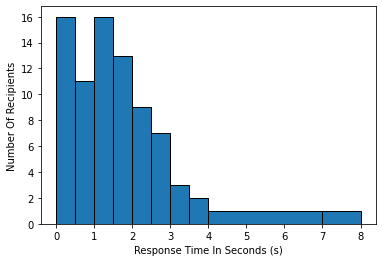

In [25]:
# As an extension to the FileHandling Exercise that I completed using Praat, this file essentially replicates the FileHandling exercise 
# but on a much larger scale by processing at least 100 TextGrid files.

import matplotlib.pyplot as plt
import pandas as Pand 
from praatio import tgio as tg
import glob
import os
import re

# First, create the array for which the data will be loaded into.
# Following this, navigate and retrieve files from the /TextGfiles directory (On My PC).
# Finally, extract and obtain the relevant data from the processing and handling of TextGrid Files.

os.chdir('C:/Users/PC/Desktop/TextGFiles') # This statement is used to change the current working directory to that of the directory or folder 
# where the TextGrid files are kept.

DrecT = r'C:/Users/PC/Desktop/TextGFiles' 
LiveSTime = []
NewRingT = []
FinalLiveS =[]
RingETime = []
MStart = []
FinalMStart = []
# The Lists above are to be utilized for appending the data from the relevant EntryLists to the aforementioned empty lists. 
# The issue or problem that is of course raised should a variable merely be assigned to the respective entryLists is that because of 
# the requirement for multiple files to be accessed via the use of a for loop, it is that these operations must take place within a
# for loop so that the values contained within multiple TextGrid files can be extracted in order to ultimately store this data and display 
# it in the form of a histogram.

for f in glob.glob1(DrecT,'*.TextGrid'):
    OpFile = tg.openTextgrid(f,readRaw=True)
  
    # Both Of The Variables Below Are For Extracting The Live Start And Ring End Values
    RingE = OpFile.tierDict['Ring End']
    Lstart = OpFile.tierDict['Live Start']
    MsgStrt = OpFile.tierDict['Msg. Start'] 
   
    # Certain Entries (Particularly the values contained within the LiveStart Entrylist can be empty reflecting how recipients sometimes may not pick up
    # the phone and/or a recorded answerphone message is played in the event that the recipients are unable to answer the phone at the time.) 

    # From extracting the relevant data from the Live Start entryList, with the data in question (given how recipients may talk at various instances 
    # during the call), it is for this reason that multiple Live Start (as well as) Live End values are labelled in the Praat TextGrid File.  
  
    LiveSVal = Lstart.entryList     # Index 0 is where the values are contained (Contains multiple values). Index [1] is where the labels are contained. 
                                    # Objective : Get only the first value. 
    LiveSTime.append(str(LiveSVal)) # Here, because the values contained within the entryLists (both Live Start and Ring End) are self-defined objects 
    RingEnd = RingE.entryList       # (i.e. that being a 'Point' Object), to resolve issues that could arise much later, it is accordingly converted to a 
    RingETime.append(str(RingEnd))  # string datatype.
    MsgStart  = MsgStrt.entryList
    MStart.append(str(MsgStart)) 
     
# Objective : Get Live Start and Ring End Times. Conventionally, in nearly all circumstances Ring End will always be labelled 
# with a value in a Praat TextGrid file.

# For certain TextGrid files, no LiveStart entry or value(s) are recorded. Accordingly, a remedy for this is touched upon in the subsequents comments
# down below.

# Additionally, due to the issue that has been mentioned above wherein multiple Live Start values might be labelled to reflect how recipients will talk 
# at various points during a call, consequently this does mean that (as stated before) multiple Live Start values will be recorded in the TextGrid file
# and as such the solution to this (which is demonstrated in the code below) is to convert the Lists (appended with data from the EntryLists) to a Pandas 
# Dataframe.

for x in LiveSTime:
  FindFloat = re.findall(r"[-+]?\d*\.\d+|\d+", x)
  Result = list(map(float, FindFloat)) 
  FinalLiveS.append(Result)

for x in RingETime:
  FTime = re.findall(r"[-+]?\d*\.\d+|\d+", x)
  Res = list(map(float,FTime)) 
  NewRingT.append(Res) 

for x in MStart: 
  MTime = re.findall(r"[-+]?\d*\.\d+|\d+", x)  
  MRes = list(map(float, MTime)) 
  FinalMStart.append(MRes)

NewLiveSt = Pand.DataFrame(FinalLiveS)
NewLiveSt.drop(NewLiveSt.columns[[1,2,3]],axis=1, inplace=True)

RingEnT = Pand.DataFrame(NewRingT)
DuplREnd = RingEnT.copy(deep=True) 

NanVals = [index for index, row in NewLiveSt.iterrows() if row.isnull().any()] 
RingEnT.drop(NanVals, inplace=True) 

MsgSt = Pand.DataFrame(FinalMStart) 
MsgSt.drop(MsgSt.columns[[1,2,3]],axis=1, inplace=True)
MsgNVal = [index for index, row in MsgSt.iterrows() if row.isnull().any()]
DuplREnd.drop(MsgNVal, inplace=True)
MsgSt.dropna(axis=0, inplace=True)

DuplNVal = [index for index, row in DuplREnd.iterrows() if row.isnull().any()] 
DuplREnd.dropna(axis=0, inplace=True)
MsgSt.drop(DuplNVal, inplace=True)

NewLiveSt.dropna(axis=0, inplace=True) 

RingNVal = [index for index, row in RingEnT.iterrows() if row.isnull().any()]
NewLiveSt.drop(RingNVal, inplace=True)

RingEnT.dropna(axis=0,inplace=True)

# For every Nan Value in NewLiveSt, you want to remove the according or correspondin Nan entries in Ring End time (and vice-versa). 
# The reasoning behind this is that for TextGrid files in which the recipient does not pick up the phone
# (for any number of reasons), no response time can be derived or determined from this and as such there is no reason to be concerned with these values.

NewLiveSt.reset_index(drop=True, inplace=True)
RingEnT.reset_index(drop=True,inplace=True) 
DuplREnd.reset_index(drop=True, inplace=True)
MsgSt.reset_index(drop=True, inplace=True)

ResponseT = NewLiveSt.subtract(RingEnT)
RoundResp = ResponseT.round(2)

AnswrMsgR = MsgSt.subtract(DuplREnd)
RoundMsgResp = AnswrMsgR.round(2)

#RoundRespAlt = RoundResp.set_axis(['Response Times For Recipients'], axis='columns', inplace=True)
#RoundRespAlt = RoundResp.plot(kind="hist",xlabel="Response Time In Seconds (s)", ylabel="Number of Recipients");

Bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,7,8]
plt.hist(RoundResp,bins=Bins,edgecolor='black')

plt.xlabel("Response Time In Seconds (s)") 
plt.ylabel("Number Of Recipients")
# In this final section of the program, the code outlined above plots the according histogram by mapping the response times 
# against how many recipients responded within that timeframe.